In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(42)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split


#### Toy example to compare stability with Euclidean distance

In [2]:
data = make_classification(n_samples=50, 
                           n_features=2, 
                           n_informative=2,
                           n_redundant=0, 
                           n_classes=2,
                           n_clusters_per_class=1, 
                           scale=10.0,
                           random_state=42) # class is split evenly, half 1 and half 0

df = pd.DataFrame(data[0], columns=["a","b"])
labels = pd.DataFrame(data[1], columns=["class"])

df_full = pd.concat([df, labels], axis=1)

num_true = 24 # number of true labels to assign to M (and false to F)
num_false = 1 # number of false labels to assign to M (and true to F)

df_full['male'] = 0 # in this example, 0 means female and 1 means male

df_true = df_full[df_full['class'] == 1]
df_false = df_full[df_full['class'] == 0]

df_true = df_true.reset_index()
df_false = df_false.reset_index()

rand_true = random.sample(range(len(df_true)), num_true)
rand_false = random.sample(range(len(df_false)), num_false)

df_true.loc[rand_true, 'male'] = 1
df_false.loc[rand_false, 'male'] = 1

df_full = pd.concat([df_true, df_false])
df_full = df_full.set_index('index')
df_full = df_full.sample(frac=1) # shuffle

df = df_full[['a', 'b', 'male']]
labels = df_full['class']

df_train = df.copy()
df_train['male'] = 0 # set feature to 0 so it's not actually used by classifier

X_train, X_test, y_train, y_test = train_test_split(df_train, labels, random_state=42)

# model = RandomForestClassifier()
model = LogisticRegression()

# Cross val score
print(np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')))

# Fit and train on test.
model.fit(X_train, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

1.0
0.8571428571428572


In [3]:
pd.concat([df, labels], axis=1)

,a,b,male,class
index,,,,
20,3.674841,10.527960,1,1
47,13.151833,-10.602302,0,0
4,7.807282,10.641737,1,1
12,0.284000,10.615357,1,1
6,5.404613,10.982430,0,0
24,12.982104,-8.017408,0,0
34,14.818515,-23.134092,0,0
44,17.942810,-15.607032,0,0
14,11.645455,-27.068026,0,0


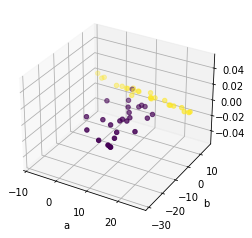

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a = df.to_numpy()[:,0]
b = df.to_numpy()[:,1]
male = df.to_numpy()[:,2]

ax.scatter(a, b, c=labels.to_numpy())

ax.set_xlabel('a')
ax.set_ylabel('b')

plt.show()

In [5]:
from swap_auditor import NaiveSwapAuditor
df['id'] = np.arange(len(df))
new = NaiveSwapAuditor(data=df, predictor=model, id_column="id",protected_classes=['male'], target_col='class')
new.calculate_all_stability(marginal_features=['a','b'])

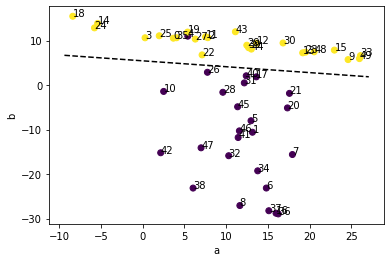

In [6]:
b_coeff = model.intercept_[0]
w1, w2, w3 = model.coef_.T
c = -b_coeff/w2
m = -w1/w2

a_min, a_max = min(a) - 1, max(a) + 1

x = np.array([a_min, a_max])
y = m*x + c

plt.plot(x, y, 'k', ls='--')
plt.scatter(a, b, c=labels.to_numpy())
plt.xlabel('a')
plt.ylabel('b')
for i, txt in enumerate(df['id']):
    plt.annotate(txt, (a[i], b[i]))

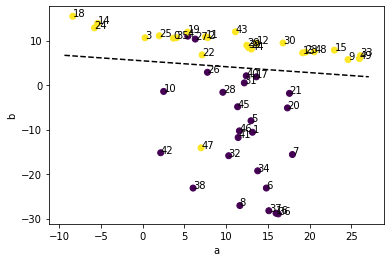

In [7]:
plt.plot(x, y, 'k', ls='--')
plt.scatter(a, b, c=male) # think M = yellow, F = purple?
plt.xlabel('a')
plt.ylabel('b')
for i, txt in enumerate(df['id']):
    plt.annotate(txt, (a[i], b[i]))

In [8]:
endpoint_0, endpoint_1 = np.array([a_min, y[0]]), np.array([a_max, y[-1]])

def get_euclidean_distance(a_x, b_x):
    return np.cross(endpoint_1 - endpoint_0, endpoint_0 - np.array([a_x, b_x]))/np.linalg.norm(endpoint_1 - endpoint_0)

df['euclidean_distance'] = df.apply(lambda x: get_euclidean_distance(x.a, x.b), axis=1)
df['stability'] = df.apply(lambda x: new._retrieve_stability_individual(int(x.id))[0], axis=1)
df['class'] = labels
print(df)

               a          b  male  id  euclidean_distance  stability  class
index                                                                      
20      3.674841  10.527960     1   0           -5.524824   0.386667      1
47     13.151833 -10.602302     0   1           14.179468   0.360000      0
4       7.807282  10.641737     1   2           -6.179772   0.386667      1
12      0.284000  10.615357     1   3           -5.166605   0.386667      1
6       5.404613  10.982430     0   4           -6.202303   0.973333      0
24     12.982104  -8.017408     0   5           11.639184   0.360000      0
34     14.818515 -23.134092     0   6           26.384281   0.360000      0
44     17.942810 -15.607032     0   7           18.512389   0.360000      0
14     11.645455 -27.068026     0   8           30.700501   0.360000      0
15     24.617950   5.719115     1   9           -3.505172   0.400000      1
16      2.511160  -1.432883     0  10            6.485305   0.360000      0
35      7.53

In [9]:
df_high_stability = df[df['stability'] > 0.9]
df_high_stability

,a,b,male,id,euclidean_distance,stability,class
index,,,,,,,
6,5.404613,10.982430,0,4,-6.202303,0.973333,0
31,6.302559,10.326288,0,27,-5.669639,0.973333,1
38,6.995736,-14.096321,1,47,18.450935,0.946667,0


In [10]:
df_low_dist = df[np.abs(df['euclidean_distance']) < 5]
df_low_dist = df_low_dist[df_low_dist['stability'] < 0.4]
df_high_dist = df[np.abs(df['euclidean_distance']) > 15]
df_high_dist = df_high_dist[df_high_dist['stability'] < 0.4]
df_high_dist

,a,b,male,id,euclidean_distance,stability,class
index,,,,,,,
34,14.818515,-23.134092,0,6,26.384281,0.36,0
44,17.942810,-15.607032,0,7,18.512389,0.36,0
14,11.645455,-27.068026,0,8,30.700501,0.36,0
0,15.979427,-28.787773,0,16,31.836788,0.36,0
28,10.309102,-15.875044,0,32,19.779587,0.36,0
40,13.783839,-19.266793,0,34,22.686153,0.36,0
25,16.250953,-28.947064,0,36,31.959080,0.36,0
37,15.118039,-28.229776,0,37,31.396625,0.36,0
3,6.038349,-23.142847,0,38,27.544873,0.36,0


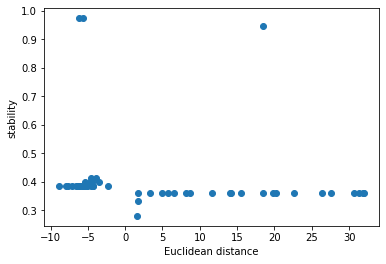

In [11]:
plt.scatter(df['euclidean_distance'], df['stability'])
plt.xlabel('Euclidean distance')
plt.ylabel('stability')
plt.show()

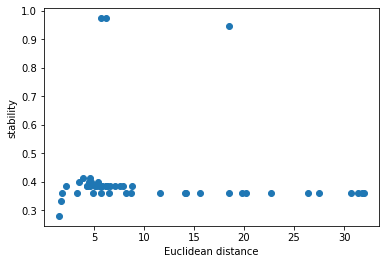

In [12]:
plt.scatter(np.abs(df['euclidean_distance']), df['stability'])
plt.xlabel('Euclidean distance')
plt.ylabel('stability')
plt.show()

In [13]:
corr = df.corr(method="pearson")
print(f'Correlation: {corr["euclidean_distance"]["stability"]}')

Correlation: -0.13271339070931


In [14]:
m = df[df['male'] == 1]
f = df[df['male'] == 0]

print(f'Average male stability: {m["stability"].mean()}')
print(f'Average male euclidean distance: {np.abs(m["euclidean_distance"]).mean()}')
print(f'Average female stability: {f["stability"].mean()}')
print(f'Average female euclidean distance: {f["euclidean_distance"].mean()}')

Average male stability: 0.41333333333333333
Average male euclidean distance: 6.012369570320816
Average female stability: 0.40480000000000005
Average female euclidean distance: 13.881902069605198


In [15]:
new._calculate_subgroup_stability()
s, marg = new._retrieve_stability_subgroup('1')
print(f'Subgroup male stability: {s}')
print(marg)

Subgroup male stability: 0.41333333333333333
Marginals:

a: 1.0
b: 0.1264
ab: 0.1136



In [16]:
s, marg = new._retrieve_stability_subgroup('0')
print(f'Subgroup female stability: {s}')
print(marg)

Subgroup female stability: 0.4048
Marginals:

a: 0.9872
b: 0.1136
ab: 0.1136

